## loading attention files

In [64]:
from glob import glob

partial_prompt_files = glob('outputs/exp1_7b/*.pkl')
full_prompt_files  = glob('outputs/exp2_7b/*.pkl')

# partial_prompt_files = [p.split('/')[-1] for p in partial_prompt_files]
# full_prompt_files = [p.split('/')[-1] for p in full_prompt_files]

print(len(full_prompt_files))
print(len(partial_prompt_files))


958
958


## getting attention on strategy tokens

In [66]:
from analyze_attention_weights import get_average_attention_over_sequence
import pickle
from transformers import AutoTokenizer
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')

def get_attention_per_strategy(files):
    data = []
    for file in files:
        with open(file, 'rb') as f:
            data.append(pickle.load(f))

    res = {}
    for example in tqdm(data):
        if example is None:
            continue
        for strategy, (tokens, attentions) in example.items():
            strategy_str = f'"{strategy}"'
            attn = get_average_attention_over_sequence(attentions, tokens, sequence=strategy_str, tokenizer=tokenizer)
            if strategy in res:
                res[strategy].append(attn)
            else:
                res[strategy] = [attn]
    return res


partial_attns = get_attention_per_strategy(partial_prompt_files)
full_attns = get_attention_per_strategy(full_prompt_files)

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [48:15<00:00,  3.02s/it]


In [4]:
import re

def get_attention_per_strategy_and_description(files):
    data = []
    for file in files:
        with open(file, 'rb') as f:
            data.append(pickle.load(f))

    res = {}
    for example in tqdm(data):
        for strategy, (tokens, attentions) in example.items():
            decoded_prompt = tokenizer.decode(tokens, skip_special_tokens=False)
            # print(decoded_prompt)
            match = re.findall(f'You are a helpful and caring friend.+{strategy} strategy\.', decoded_prompt)[0]

            attn = get_average_attention_over_sequence(attentions, tokens, sequence=match, tokenizer=tokenizer)
            if strategy in res:
                res[strategy].append(attn)
            else:
                res[strategy] = [attn]
    return res


partial_attns = get_attention_per_strategy_and_description(partial_prompt_files)
full_attns = get_attention_per_strategy_and_description(full_prompt_files)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:50<00:00,  1.06it/s]


## visualize results

In [67]:
print({k: len(v) for k,v in partial_attns.items()})
print({k: len(v) for k,v in full_attns.items()})

{'Affirmation': 294, 'Normalize Experiences': 307, 'Reflective Statements': 305, 'Reframe Negative Thoughts': 270, 'Chit Chat': 266, 'Share Information': 296, 'Clarification': 273, 'Promote Self-Care Practices': 264, 'Provide Different Perspectives': 289, 'Avoid Judgment and Criticism': 288, 'Stress Management': 285, 'Suggest Options': 297, 'Collaborative Planning': 286, 'Emotional Validation': 297, 'Offer Hope': 289}
{'Affirmation': 294, 'Normalize Experiences': 307, 'Reflective Statements': 305, 'Reframe Negative Thoughts': 270, 'Chit Chat': 266, 'Share Information': 296, 'Clarification': 273, 'Promote Self-Care Practices': 264, 'Provide Different Perspectives': 289, 'Avoid Judgment and Criticism': 288, 'Stress Management': 285, 'Suggest Options': 297, 'Collaborative Planning': 286, 'Emotional Validation': 297, 'Offer Hope': 289}


In [5]:
import numpy as np
import seaborn as sns
import pandas as pd

partial_attns_avg = {k: np.mean(v) for k,v in partial_attns.items()}
full_attns_avg = {k: np.mean(v) for k,v in full_attns.items()}

strs1 = list(partial_attns_avg.keys())
partial_vals = list(partial_attns_avg.values())
prompt1 = ['partial' for _ in strs1]

strs2 = list(full_attns_avg.keys())
full_vals = list(full_attns_avg.values())
prompt2 = ['full' for _ in strs2]

df = pd.DataFrame({'strategy': strs1+strs2, 'prompt': prompt1+prompt2, 'attention': partial_vals+full_vals})


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


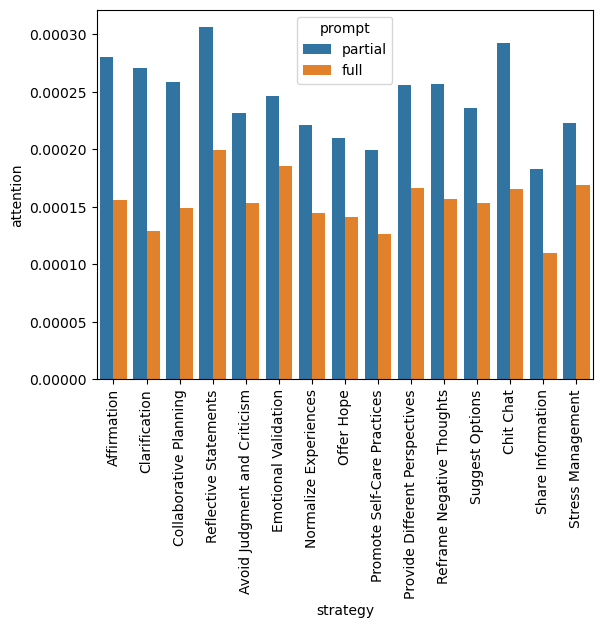

In [6]:
import matplotlib.pyplot as plt

sns.barplot(df, x='strategy', y='attention', hue='prompt')
plt.xticks(rotation=90)
plt.show()

## measuring attention vs number of utterances in history

### get length of inputs

In [82]:
import json

partial_json_files = glob('outputs/exp1_7b/*.json')
full_json_files  = glob('outputs/exp2_7b/*.json')

def get_dialog_lens(files):
    data = []
    for file in files:
        with open(file, 'r') as f:
            data.append(json.load(f))
    
    res = {}
    for example in tqdm(data):
        if example is None:
            continue
    
        n_turns = len(example['dialog'])
        strategies = list(example['responses'].keys())
        for stra in strategies:
            if stra in res:
                res[stra].append(n_turns)
            else:
                res[stra] = [n_turns]
    return res

dialog_lens_partial = get_dialog_lens(partial_json_files)
dialog_lens_full = get_dialog_lens(full_json_files)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:00<00:00, 1166708.26it/s]


### match lengths with attentions

In [85]:
import pandas as pd

def match_len_attn(dialog_lens, stra_attns):
    df_list = []
    for strategy in dialog_lens.keys():
        lens = dialog_lens[strategy]
        attns = stra_attns[strategy]
        assert len(lens) == len(attns)
    
        strategies = [strategy] * len(lens)
        df_list.extend([{'n_utt': x, 'attn': y, 'strategy': z} for x, y, z in zip(lens, attns, strategies)])
        
    df = pd.DataFrame(df_list)
    return df

partial_df = match_len_attn(dialog_lens_partial, partial_attns)
partial_df['prompt'] = 'partial'
full_df = match_len_attn(dialog_lens_full, full_attns)
full_df['prompt'] = 'full'

partial_df, full_df

(      n_utt      attn                strategy   prompt
 0        17  0.000511  Collaborative Planning  partial
 1        11  0.000245  Collaborative Planning  partial
 2        17  0.000267  Collaborative Planning  partial
 3        17  0.000232  Collaborative Planning  partial
 4         5  0.000274  Collaborative Planning  partial
 ...     ...       ...                     ...      ...
 4301     13  0.000197   Normalize Experiences  partial
 4302     11  0.000329   Normalize Experiences  partial
 4303     13  0.000279   Normalize Experiences  partial
 4304     21  0.000423   Normalize Experiences  partial
 4305      9  0.000549   Normalize Experiences  partial
 
 [4306 rows x 4 columns],
       n_utt      attn                strategy prompt
 0        17  0.000223  Collaborative Planning   full
 1        11  0.000065  Collaborative Planning   full
 2        17  0.000073  Collaborative Planning   full
 3        17  0.000127  Collaborative Planning   full
 4         5  0.000192  Collab

<AxesSubplot:xlabel='n_utt', ylabel='attn'>

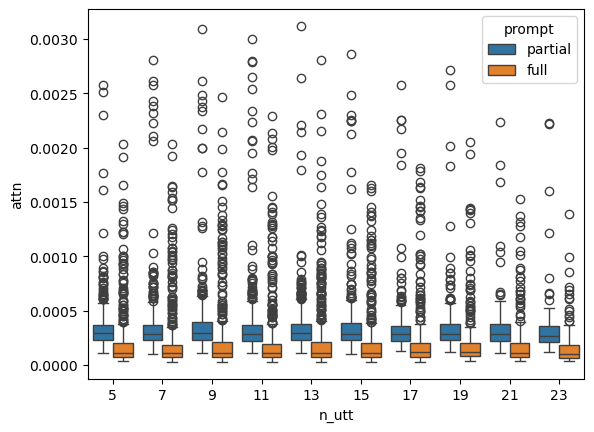

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.concat([partial_df, full_df], axis=0)

# for strategy in list(set(df['strategy'])):
#     cur_df = df[df['strategy']==strategy]
#     sns.boxplot(data=cur_df, x='n_utt', y='attn', hue='prompt')
#     plt.show()

sns.boxplot(data=df, x='n_utt', y='attn', hue='prompt')

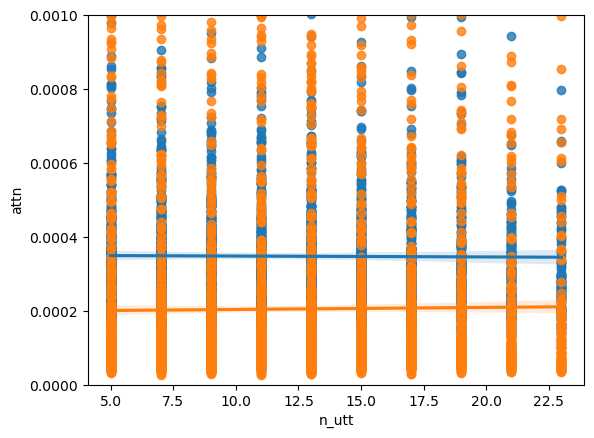

In [96]:
sns.regplot(data=partial_df, x='n_utt', y='attn')
sns.regplot(data=full_df, x='n_utt', y='attn')
plt.ylim(0, 0.001)
plt.show()

# measuring predictability of responses for each prompting schema

## loading datasets

In [22]:
import json
from glob import glob

ds1_path = 'outputs/exp1_13b/*.json'
ds2_path = 'outputs/exp2_13b/*.json'

ds1_files = glob(ds1_path)
ds2_files = glob(ds2_path)

def load_dataset(files):
    ds = []
    for p in files:
        with open(p, 'r') as f:
            d = json.load(f)
            ds.append(d)
    return ds

ds_1 = load_dataset(ds1_files)
ds_2 = load_dataset(ds2_files)
print(f"len ds1: {len(ds_1)} len ds2: {len(ds_2)}")

len ds1: 515 len ds2: 515


## convert to seq classification dataset

In [23]:
def to_seq_classification_ds(ds):
    seqs = []
    labels = []
    for d in ds:
        if d is None:
            print("Ran into empty json")
            continue
        for strategy, resp in d['responses'].items():
            seqs.append(resp)
            labels.append(strategy)

    return seqs, labels

ds1_x, ds1_y = to_seq_classification_ds(ds_1)
ds2_x, ds2_y = to_seq_classification_ds(ds_2)

ds2_x[:3], ds2_y[:3]

(["It's not a burden to share your issues with someone you trust. They may have valuable insights or advice that can help you. Plus, they may be able to relate to what you're going through and offer support. It's okay to ask for help when you need it. Remember, you don't have to go through this alone.",
  "It's not a burden to share your issues with someone you trust. They may have valuable insights or advice that can help you. Plus, they may be able to relate to what you're going through and offer support. It's okay to ask for help when you need it. Remember, you don't have to go through this alone.",
  "It's not a burden to share your issues with someone you trust. It's actually a sign of strength to acknowledge when you need help and to seek it out. And the person you're talking to may have some valuable insights or advice that can help you. Plus, talking about your feelings can help you process them and gain clarity. It's okay to not have all the answers, and it's okay to ask for h

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def train_and_report(ds_x, ds_y):
    vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9)
    X = vectorizer.fit_transform(ds_x)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(ds_y)

    X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2)
    
    model = LogisticRegressionCV(max_iter=100, cv=5)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print('accuracy: ', acc)

train_and_report(ds1_x, ds1_y)
train_and_report(ds2_x, ds2_y)


[nltk_data] Downloading package stopwords to /Users/navid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/navid/miniforge3/envs/rho/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/navid/miniforge3/envs/rho/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.htm

accuracy:  0.29336188436830835


/Users/navid/miniforge3/envs/rho/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/navid/miniforge3/envs/rho/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

accuracy:  0.07494646680942184


In [62]:
vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9, ngram_range=(2, 3))
X = vectorizer.fit_transform(ds1_x)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(ds1_y)

X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('accuracy: ', acc)

accuracy:  0.2698072805139186


In [63]:
for i in range(15):
    coefficients = model.coef_[i]
    strategy = label_encoder.inverse_transform([i])[0]
    
    # Step 4: Map coefficients to words
    feature_names = vectorizer.get_feature_names_out()
    word_coefficient_tuples = list(zip(feature_names, coefficients))
    
    # Step 5: Sort and display
    sorted_word_coefficients = sorted(word_coefficient_tuples, key=lambda x: x[1], reverse=True)
    print("*"*100)
    print("strategy: ", strategy)
    print("*"*100)
    for word, score in sorted_word_coefficients[:10]:
        print(f"{word} -> {score}")

****************************************************************************************************
strategy:  Affirmation
****************************************************************************************************
truly commendable -> 0.29938507029288713
takes lot -> 0.29933284565162044
good work -> 0.2980671275251496
keep good -> 0.2980671275251496
keep good work -> 0.2980671275251496
lot courage -> 0.28891947089338166
takes lot courage -> 0.28891947089338166
pushing forward -> 0.2695613670603203
keep pushing -> 0.2654552319574077
want know -> 0.260929429227909
****************************************************************************************************
strategy:  Avoid Judgment and Criticism
****************************************************************************************************
take care -> 0.4457781163912158
okay take time -> 0.38776250190271466
completely understandable -> 0.3295267428958669
completely understandable feel -> 0.30852534442544616
ready 